## Alignment methods
We will be using DTW to perform audio to score alignment. The matrix cost of the DTW will be computed using different features, later on we will compare which of these features is better for our current dataset.

In [1]:
#Needed imports
#you might to install these libraries:
%pip install pretty_midi
%pip install librosa
%pip install pyfluidsynth  
import sys
import numpy as np
import librosa, pretty_midi
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
import os


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: C:\Users\ifc04\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
"""
This function aligns the chroma features of the score and the performance
and returns the alignment path as a numpy array of tuples (s,t) where s is the
time in the score and t is the time in the performance.
"""
def align_chroma(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
    perf,_ = librosa.load(perf + '.wav', sr=fs)
    score_chroma = librosa.feature.chroma_stft(y=score_synth, sr=fs, tuning=0, norm=2,
                                               hop_length=stride, n_fft=n_fft)
    score_logch = librosa.power_to_db(score_chroma, ref=score_chroma.max())
    perf_chroma = librosa.feature.chroma_stft(y=perf, sr=fs, tuning=0, norm=2,
                                              hop_length=stride, n_fft=n_fft)
    perf_logch = librosa.power_to_db(perf_chroma, ref=perf_chroma.max())
    D, wp = librosa.sequence.dtw(X=score_logch, Y=perf_logch)
    path = np.array(list(reversed(np.asarray(wp))))

    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)
"""
This function aligns the spectrogram features of the score and the performance
and returns the alignment path as a numpy array of tuples (s,t) where s is the
time in the score and t is the time in the performance.
"""
def align_spectra(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    score_synth = pretty_midi.PrettyMIDI(score_midi).synthesize(fs=fs)
    perf,_ = librosa.load(perf + '.wav', sr=fs)
    score_spec = np.abs(librosa.stft(y=score_synth, hop_length=stride, n_fft=n_fft))**2
    score_logspec = librosa.power_to_db(score_spec, ref=score_spec.max())
    perf_spec = np.abs(librosa.stft(y=perf, hop_length=stride, n_fft=n_fft))**2
    perf_logspec = librosa.power_to_db(perf_spec, ref=perf_spec.max())
    D, wp = librosa.sequence.dtw(X=score_logspec, Y=perf_logspec)
    path = np.array(list(reversed(np.asarray(wp))))
    return np.array([(s,t) for s,t in dict(reversed(wp)).items()])*(stride/fs)

#sort of wrapper function
def align_all(score_midi, perf, fs=44100, stride=512, n_fft=4096):
    align1=align_chroma(score_midi, perf, fs, stride, n_fft)
    align2=align_spectra(score_midi, perf, fs, stride, n_fft)
    return align1,align2 #later on we'll save these alignments in a file


## Aligning each muiñeira with its corresponding performance

In [2]:
#Read data folder and print all its subfolders
data_dir = 'data'
list_muiñeiras = []
for root, dirs, files in os.walk(data_dir):
    for dir in dirs:
        #dir - name of the folder; path - path to the folder
        path=os.path.join(root,dir)
        if 'performance' not in path and   'score' not in path:
            list_muiñeiras.append(path)

#access the first muiñeira
"""
Gets the path to the muiñeira folder and aligns the score and performance
saves the alignment in a text file
"""
def align_muiñeira(muiñeira_path):
    try:
        os.mkdir(muiñeira_path+'/alignments')
        #access the score and performance of the first muiñeira
        score_path=muiñeira_path+'/score'
        perf_path=muiñeira_path+'/performance'
        #get wav file in performance folder
        perf_wav=[f for f in os.listdir(perf_path) if f.endswith('.wav')][0]
        #get midi file in score folder
        score_midi=[f for f in os.listdir(score_path) if f.endswith('.mid')][0]
        #align the score and performance
        align1,align2=align_all(score_path+'/'+score_midi, perf_path+'/'+perf_wav[:-4])
        #save first alignment in text file, row1 is time in score, row2 is time in performance
        #add a header to the file
        header='score_time, perf_time'
        #create new folder in muiñeira_path called 'alignments'
        #save the alignment in the new folder
        
        np.savetxt(muiñeira_path+'/alignments/align_chroma.txt', align1, delimiter=',', header=header)
        #save second alignment in text file, row1 is time in score, row2 is time in performance
        np.savetxt(muiñeira_path+'/alignments/align_spectra.txt', align2, delimiter=',', header=header)
    except Exception as e:
        print(e)


## Visualizing the results

We well create some helper functions to show the results of the alignment

In [6]:
def plot_alignment(align):
    #plot the alignment 
    #x - score, y - performance
    plt.figure(figsize=(15,5))
    #align[:,0] - time in score
    #align[:,1] - time in performance
    plt.plot(align[:,1], align[:,0])
    plt.xlabel('Time in performance')
    plt.ylabel('Time in score')
    
    
    plt.show()

def plot_both_alignments(align1, align2):
    #plot the alignment x - score, y - performance
    plt.figure(figsize=(15,5))
    plt.plot(align1[:,1], align1[:,0], label='Chroma')
    plt.plot(align2[:,1], align2[:,0], label='Spectra')
    plt.xlabel('Time in performance')
    plt.ylabel('Time in score')
    plt.legend(['Chroma', 'Spectra'])
    plt.show()

#read the alignment from the text file
def read_alignment(file_path):
    return np.loadtxt(file_path, delimiter=',', skiprows=1)

In [47]:
#Example of use:
index=9
print(list_muiñeiras[index])
align_muiñeira(list_muiñeiras[index])


data\Muiñeira de Cernades


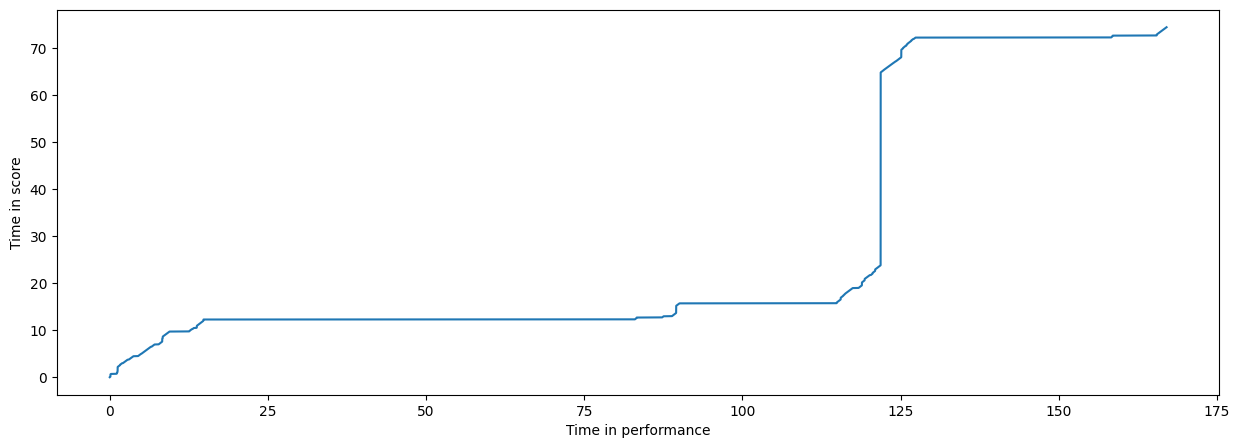

In [7]:
plot_alignment(read_alignment('data/Muiñeira de Forcarei'+'/alignments/align_chroma.txt'))

In [8]:
plot_alignment(read_alignment(list_muiñeiras[index]+'/alignments/align_spectra.txt'))

NameError: name 'index' is not defined

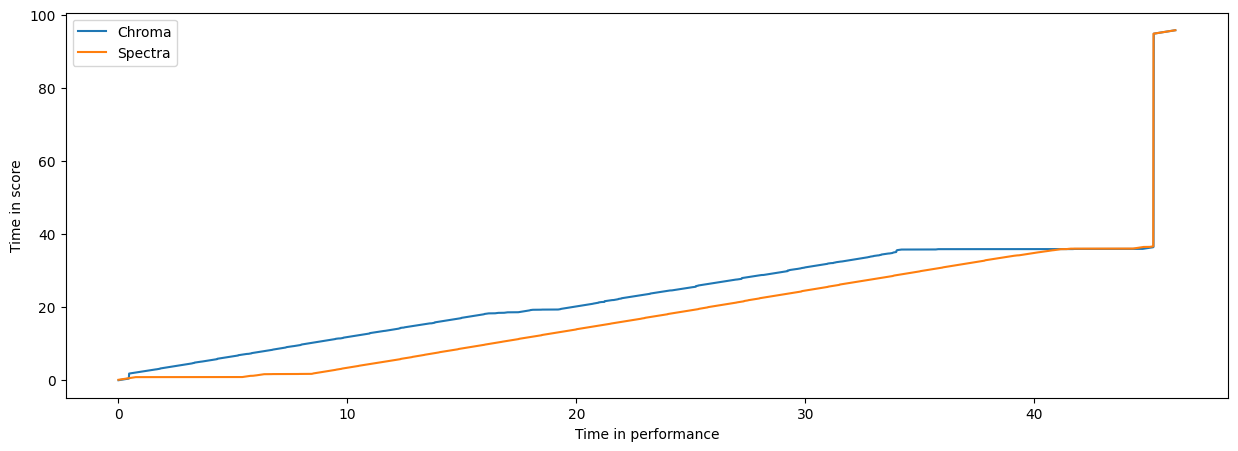

In [29]:
#plot both alignments
plot_both_alignments(read_alignment(list_muiñeiras[index]+'/alignments/align_chroma.txt'),
                        read_alignment(list_muiñeiras[index]+'/alignments/align_spectra.txt'))

Now let's align every track

In [7]:
for muiñeira in list_muiñeiras:
    align_muiñeira(muiñeira)



Folder already exists
Folder already exists


data\Muiñeira de Pazos de Borbén


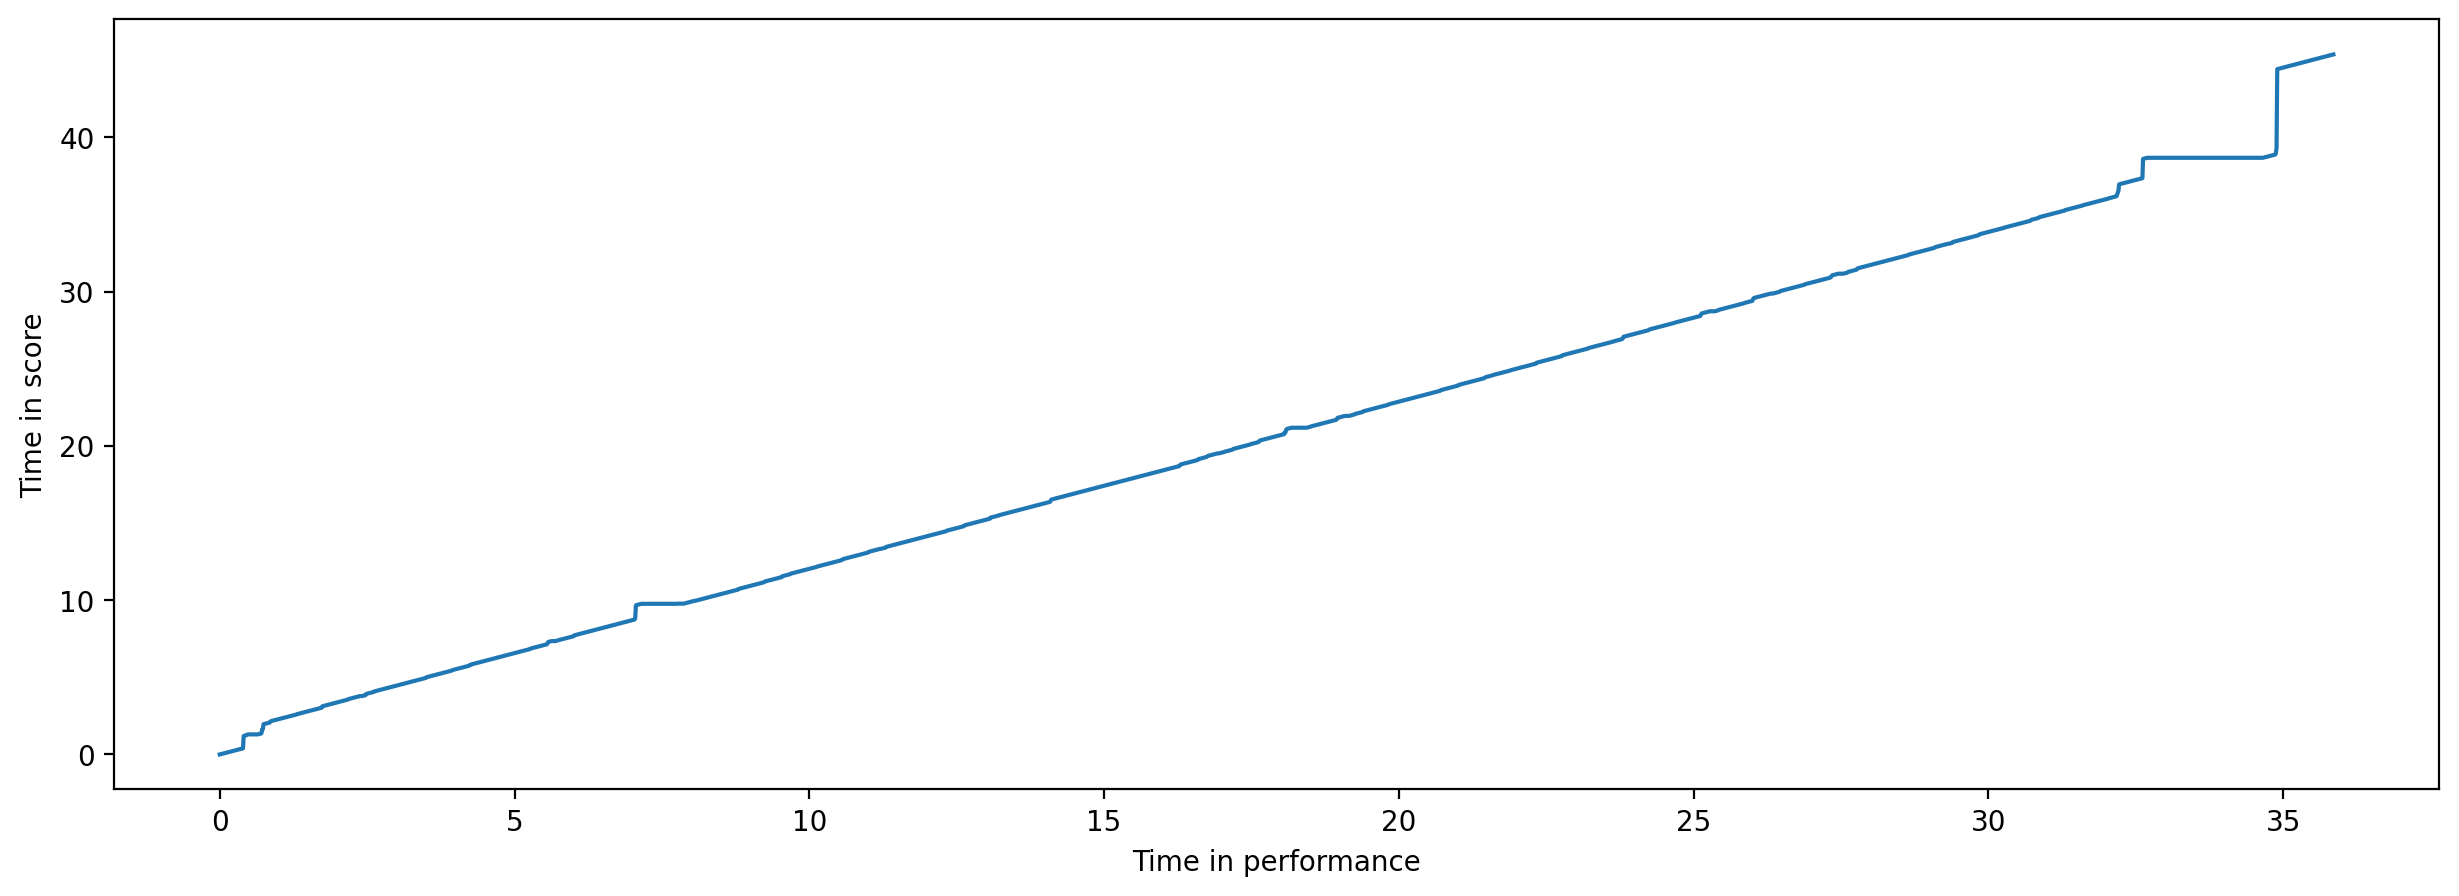

In [55]:
muiñeira_index=[i for i, s in enumerate(list_muiñeiras) if 'Muiñeira de Pazos' in s][0]
print(list_muiñeiras[muiñeira_index])

#get alignment results
align_chroma=read_alignment(list_muiñeiras[muiñeira_index]+'/alignments/align_chroma.txt')
align_spectra=read_alignment(list_muiñeiras[muiñeira_index]+'/alignments/align_spectra.txt')
#plot both alignments
plot_alignment(align_chroma)

# Evaluation of alignment 
This function takes in the paths to two alignment files - groundtruth and dtw_alignment, along with a parameter called sensibility. It reads these alignment files using the read_alignment function and extracts the time in the score and the time in the performance for each note from the groundtruth and dtw_alignment files.

It then compares the time in the score and time in the performance for each note from the groundtruth file with the closest time in the score and time in the performance for each note from the dtw_alignment file, and checks if they are within (sensitivity) seconds of each other. If they are, the note is considered aligned, and the counter variable is incremented. Finally, the function returns the proportion of aligned notes out of the total number of notes in the groundtruth file, i.e., the accuracy of the alignment. The sensibility parameter is used to control how close the times need to be to be considered aligned.

In [7]:
#Def function that reads groundtruth and dtw alignment
#and returns accuracy
"""
groundtruth_path - path to groundtruth
dtw_alignment_path - path to dtw alignment
sensibility - time in seconds that the alignment can be off
returns accuracy of the alignment
"""
def get_accuracy(groundtruth_path, dtw_alignment_path,sensibility):
    #groundtruth - numpy array with shape (n,2)
    #dtw_alignment - numpy array with shape (m,2)
    #n - number of notes in the score
    #m - number of notes in the performance
    groundtruth=read_alignment(groundtruth_path)
    #groundtruth[:,0] - time in score
    #groundtruth[:,1] - time in performance
    #dtw_alignment[:,0] - time in score
    #dtw_alignment[:,1] - time in performance
    dtw_alignment=read_alignment(dtw_alignment_path)
    #get the number of notes in the score
    n=groundtruth.shape[0]
    #loop through the notes in the groundtruth
    #and check if the time in the performance is within 0.25s of the time in the score
    #if it is, then the note is aligned
    #if it is not, then the note is not aligned
    #count the number of aligned notes
    #return the accuracy
    counter=0
    for i in range(n):
        #get the time in the score
        groundtruth_score=groundtruth[i,0]
        #get the time in the performance
        groundtruth_performance=groundtruth[i,1]
        #check if the time in the performance is within 0.25s of the time in the score
        dtw_score=dtw_alignment[:,0]
        dtw_performance=dtw_alignment[:,1]
        #get the index of the closest time in the score
        index_score=np.argmin(np.abs(dtw_score-groundtruth_score))
        #get the index of the closest time in the performance
        index_performance=np.argmin(np.abs(dtw_performance-groundtruth_performance))
        #get the time in the score
        dtw_score=dtw_score[index_score]
        #get the time in the performance
        dtw_performance=dtw_performance[index_performance]
        #check if the time in the performance is within 0.25s of the time in the score
        if np.abs(dtw_score-groundtruth_score)<sensibility and np.abs(dtw_performance-groundtruth_performance)<sensibility:

            counter=counter+1

    
    return counter/n

    #get the number of notes in the performance that are aligned with the score

 
#Try with different sensibilities
sensibilities=[0.005, 0.007, 0.01, 0.015, 0.02, 0.025]
for sensibility in sensibilities:
    result=get_accuracy('./groundtruth/groundtruth_Pazos_de_Borben.txt',
            'data/Muiñeira de Pazos de Borbén/'+'/alignments/align_chroma.txt',sensibility)
    print("For a sensibility value of "+ str(sensibility) +" we have an accuracy of "+ str(result)+" in the chroma alignment")


print("")

for sensibility in sensibilities:
    result=get_accuracy('./groundtruth/groundtruth_Pazos_de_Borben.txt',
            'data/Muiñeira de Pazos de Borbén/'+'/alignments/align_spectra.txt',sensibility)
    print("For a sensibility value of "+ str(sensibility) +" we have an accuracy of "+ str(result)+" in the spectral alignment")




For a sensibility value of 0.005 we have an accuracy of 0.49523809523809526 in the chroma alignment
For a sensibility value of 0.007 we have an accuracy of 0.7047619047619048 in the chroma alignment
For a sensibility value of 0.01 we have an accuracy of 0.780952380952381 in the chroma alignment
For a sensibility value of 0.015 we have an accuracy of 0.8476190476190476 in the chroma alignment
For a sensibility value of 0.02 we have an accuracy of 0.8857142857142857 in the chroma alignment
For a sensibility value of 0.025 we have an accuracy of 0.9238095238095239 in the chroma alignment

For a sensibility value of 0.005 we have an accuracy of 0.5714285714285714 in the spectral alignment
For a sensibility value of 0.007 we have an accuracy of 0.780952380952381 in the spectral alignment
For a sensibility value of 0.01 we have an accuracy of 0.8571428571428571 in the spectral alignment
For a sensibility value of 0.015 we have an accuracy of 0.9619047619047619 in the spectral alignment
For a